In [21]:
import re
import nltk
import sklearn
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt

from pprint              import pprint
from bokeh.io            import output_notebook, show
from bokeh.models        import ColumnDataSource
from bokeh.palettes      import Spectral6
from bokeh.plotting      import figure
from lib.data_preprocess import Preprocess
from nltk.corpus         import stopwords 
from nltk.tokenize       import word_tokenize
from nltk.stem           import WordNetLemmatizer
from bs4                 import BeautifulSoup
from PIL                 import Image
from wordcloud           import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm                import tqdm_notebook as tqdm
from scipy               import stats

# plot setting
output_notebook()
sns.set_style('whitegrid')
param = {'figure.figsize': (16, 8),
         'axes.titlesize': 18,
         'axes.labelsize': 16}
plt.rcParams.update(param)

# ntlk setting
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


Loading BokehJS ...

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yihsiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yihsiang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yihsiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data preprocessing

In [2]:
train_path = 'dataset/labeledTrainData.tsv'
test_path  = 'dataset/testData.tsv'

# read in the dataset
pp                = Preprocess()
train_df, test_df = pp.read_file(train_path, test_path, sep='\t')

# check for missing value
print('Training set:')
pp.check_na(train_df)
print()

print('Test set:')
pp.check_na(test_df)

Training set:
============== Data Info ==============
Number of rows: 25000
Number of cols: 3
========== Missing Data Info ==========
     Columns  Count DataType
0         id      0   object
1  sentiment      0    int64
2     review      0   object

Test set:
============== Data Info ==============
Number of rows: 25000
Number of cols: 2
========== Missing Data Info ==========
  Columns  Count DataType
0      id      0   object
1  review      0   object


In [3]:
display(train_df[['id', 'review', 'sentiment']].head(10))

,id,review,sentiment
0,5814_8,With all this stuff going down at the moment w...,1
1,2381_9,"\The Classic War of the Worlds\"" by Timothy Hi...",1
2,7759_3,The film starts with a manager (Nicholas Bell)...,0
3,3630_4,It must be assumed that those who praised this...,0
4,9495_8,Superbly trashy and wondrously unpretentious 8...,1
5,8196_8,I dont know why people think this is such a ba...,1
6,7166_2,"This movie could have been very good, but come...",0
7,10633_1,I watched this video at a friend's house. I'm ...,0
8,319_1,"A friend of mine bought this film for £1, and ...",0
9,8713_10,<br /><br />This movie is full of references. ...,1


In [4]:
stop_words = set(stopwords.words('english'))

In [5]:
def text_process(df):
    # convert it to lower space
    df.review = df.review.str.lower()

    # pattern
    nw_removal  = lambda review: re.sub(r'[^A-Za-z\s]' , ' ', review)
    spc_removal = lambda review: re.sub(r'[\s]+'      , ' ', review)
    tag_removal = lambda review: BeautifulSoup(review, 'lxml').get_text()

    # replace words or substrings which match the pattern
    df.review = df.review.apply(tag_removal)
    df.review = df.review.apply(nw_removal)
    df.review = df.review.apply(spc_removal)
    
    return df

def lemmatize(review):
    lemmatization = WordNetLemmatizer()
    stop_words    = set(stopwords.words('english'))
    
    # tokenize, lemmatize and stop words removal
    tokens            = word_tokenize(review)
    lemmatized_tokens = list(map(lambda x: lemmatization.lemmatize(x, pos='v'), tokens))
    meaningful_tokens = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    
    return meaningful_tokens


# clean the reviews
train_df = text_process(train_df)
test_df  = text_process(test_df)

# lemmatize the reviews
train_df['review_tokenized'] = list(map(lemmatize, train_df.review.values.copy()))
test_df['review_tokenized']  = list(map(lemmatize, test_df.review.values.copy()))

# plotting wordcloud
stop_words   = set(stopwords.words('english'))
bad_review   = train_df.loc[train_df['sentiment'] == 0, 'review'].values.copy()
good_review  = train_df.loc[train_df['sentiment'] == 1, 'review'].values.copy()


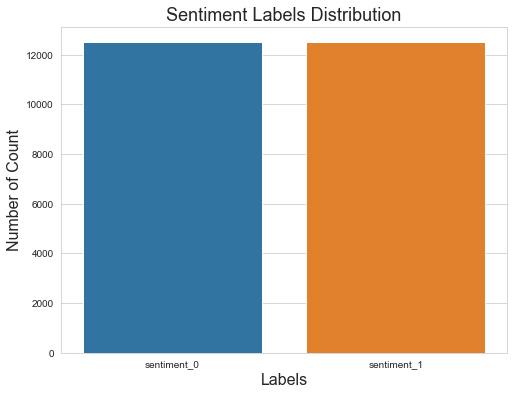

In [6]:
labels, counts = np.unique(train_df.sentiment.values, return_counts=True)
labels         = ['sentiment_' + str(label) for label in labels]

plt.figure(figsize=(8,6))
plt.title('Sentiment Labels Distribution')
plt.xlabel('Labels')
plt.ylabel('Number of Count')
sns.barplot(x=labels, y=counts)
plt.show()



In [7]:
def get_high_frequent_word(feature_name, reviews, max_length=200):
    word_count = {w: 0 for w in feature_name}

    for sentence in reviews:
        for w in sentence.split():
            if w in word_count.keys():
                word_count[w] += 1
                
    high_frequent_words = np.array(sorted(word_count.items(), key = lambda kv:(kv[1], kv[0])))    
                
    return high_frequent_words[-max_length:,0]



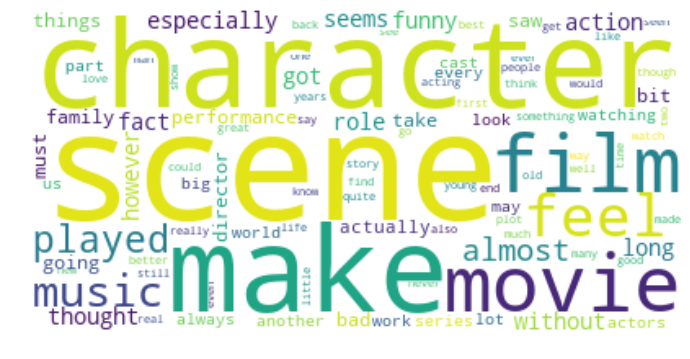

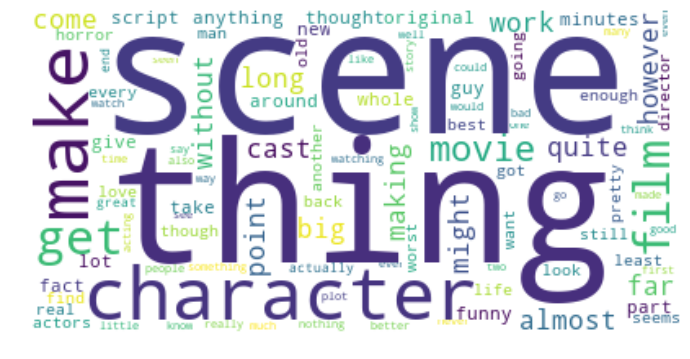

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer   = TfidfVectorizer(sublinear_tf=True, analyzer='word', max_features=500)
bad_vct      = vectorizer.fit_transform(bad_review)
hf_words     = get_high_frequent_word(vectorizer.get_feature_names(), bad_review)
bad_review   = " ".join(w for w in hf_words)
bad_wdcloud  = WordCloud(stopwords=stop_words, background_color="white").generate(bad_review)

vectorizer   = TfidfVectorizer(sublinear_tf=True, analyzer='word', max_features=500)
good_vct     = vectorizer.fit_transform(good_review)
hf_words     = get_high_frequent_word(vectorizer.get_feature_names(), good_review)
good_review  = " ".join(w for w in hf_words)
good_wdcloud = WordCloud(stopwords=stop_words, background_color="white").generate(good_review)

plt.figure(figsize=(16,6))
plt.imshow(good_wdcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.figure(figsize=(16,6))
plt.imshow(bad_wdcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [13]:
%%time
train_df['review_tokenized'] = list(map(lemmatize, train_df.review.values.copy()))
test_df['review_tokenized']  = list(map(lemmatize, test_df.review.values.copy()))


CPU times: user 1min 22s, sys: 1.63 s, total: 1min 24s
Wall time: 1min 24s


In [36]:
print('Original Sentence (Sentiment value = {}):'.format(train_df.sentiment[0]))
print(train_df.review.values[0], '\n')

print('Normalize Sentence (Sentiment value = {}):'.format(train_df.sentiment[0]))
print(" ".join(w for w in train_df.review_tokenized.values[0]))

Original Sentence (Sentiment value = 1):
with all this stuff going down at the moment with mj i ve started listening to his music watching the odd documentary here and there watched the wiz and watched moonwalker again maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent moonwalker is part biography part feature film which i remember going to see at the cinema when it was originally released some of it has subtle messages about mj s feeling towards the press and also the obvious message of drugs are bad m kay visually impressive but of course this is all about michael jackson so unless you remotely like mj in anyway then you are going to hate this and find it boring some may call mj an egotist for consenting to the making of this movie but mj and most of his fans would say that he made it for the fans which if true is really nice of him the actual feature film bit when it fi

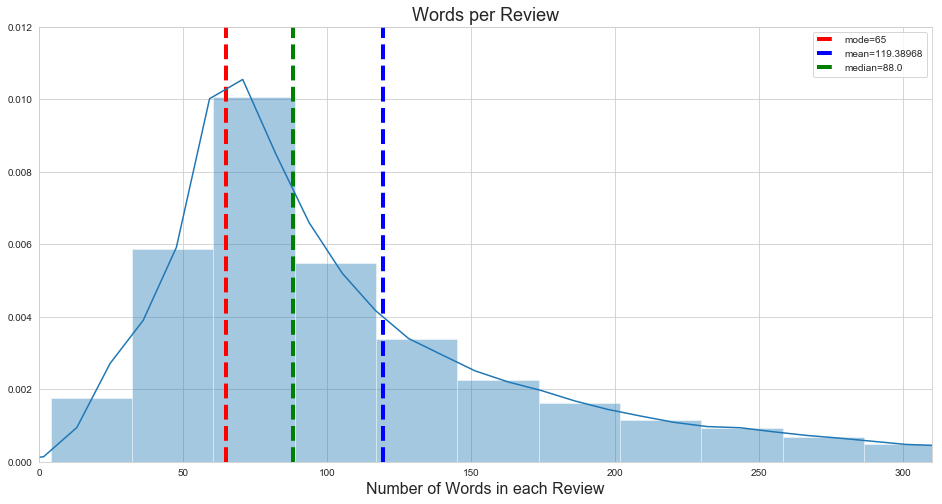

In [32]:
review_length = np.array(list(map(len, train_df.review_tokenized.values.copy())))
mode          = stats.mode(review_length)[0][0]
mean          = np.mean(review_length)
median        = np.median(review_length)
ymin, ymax    = 0, 0.012

plt.figure(figsize=(16,8))
plt.title('Words per Review')
plt.xlabel('Number of Words in each Review')
plt.xlim([0, np.percentile(review_length, 95)])  # check where the 95% of distribution lies on
plt.ylim([0, ymax])

plt.vlines(mode  , ymin=0, ymax=ymax, linestyle='--', linewidth=4, colors='red'  , label=f'mode={mode}')
plt.vlines(mean  , ymin=0, ymax=ymax, linestyle='--', linewidth=4, colors='blue' , label=f'mean={mean}')
plt.vlines(median, ymin=0, ymax=ymax, linestyle='--', linewidth=4, colors='green', label=f'median={median}')
sns.distplot(review_length)

plt.legend()
plt.show()


In [ ]:
train  , valid   = pp.train_valid_split(train_df)
train_x, valid_x = train.review_tokenized.values.copy(), valid.review_tokenized.values.copy()
train_y, valid_y = train.sentiment.values.copy()       , valid.sentiment.values.copy()